In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import neuro_morpho_toolbox as nmt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator
import pickle

min_max_scaler = MinMaxScaler()
plt.style.use(['science', 'no-latex'])

def reassign_region_id():
    region_used=nmt.bs.selected_regions
    origin_ccf = np.array(nmt.annotation.array[:, :, :], dtype=np.uint32)
    selected_annotaion = np.zeros_like(nmt.annotation.array, dtype=np.uint32)
    for region in region_used:
        #get its child region
        child_regions = nmt.bs.get_all_child_id(region)
        if len(child_regions) == 0:
            ix, iy, iz = np.where(origin_ccf == region)
            selected_annotaion[ix, iy, iz] = region
            continue
        for childregion in child_regions:
            ix, iy, iz = np.where(origin_ccf == childregion)
            selected_annotaion[ix, iy, iz] = region
    print('processing finished, reassign region id to its parent_id')
    return selected_annotaion

def get_region_swc(cswc,
                   annotation=nmt.annotation,
                   brain_structure=nmt.bs,
                   region_used=None):
    tp = cswc.copy()
    tp = pd.DataFrame(
        {
            "x": np.array(np.array(tp.x),dtype="int32"),
            "y": np.array(np.array(tp.y),dtype="int32"),
            "z": np.array(np.array(tp.z),dtype="int32")
        },
        index=tp.index)
    tp = tp[((tp.x >= 0) & (tp.x < annotation.size['x']) & (tp.y >= 0) &
             (tp.y < annotation.size['y']) & (tp.z >= 0) &
             (tp.z < annotation.size['z']))]

    # Add region id to the dataframe
    if region_used is None:
        region_used = nmt.bs.selected_regions
        dict_to_used = nmt.bs.dict_to_selected
    else:
        assert all([
            (i in brain_structure.level.index.tolist()) for i in region_used
        ]), "Given regions invalid. Please check 'region_used'."
        dict_to_used = {}
        for cur_region in region_used:
            child_ids = nmt.bs.get_all_child_id(cur_region)
            for i in child_ids:
                dict_to_used[i] = cur_region
    tp["region_id"] = np.array(annotation.array[tp.x, tp.y, tp.z], dtype=int)
    tp = tp[tp.region_id.isin(list(dict_to_used.keys()))]
    tp["region_id"] = np.array(tp["region_id"].map(dict_to_used), dtype=int)
    res = cswc.copy()
    res['region_id'] = 0
    res.loc[tp.index, 'region_id'] = tp['region_id']
    return res

def get_soma_region(infile):
    inswc=nmt.swc.neuron(infile).swc
    rootnum=inswc[inswc.parent<0].shape[0]
    if rootnum != 1:
        print('Soma error: ', infile.split('/')[-1],' ; size= ', rootnum)
        return 'error'
    soma=inswc[inswc.parent<0].copy()
    soma['x']=(soma['x']/25)
    soma['y']=(soma['y']/25)
    soma['z']=(soma['z']/25)
    somar=get_region_swc(cswc=soma,annotation=my_annotation)
    soma_rid=somar['region_id'].tolist()[0]
    if soma_rid >0:
        return nmt.bs.id_to_name(soma_rid)
    return 'error'

ccf_reassigned_f='/Users/jiangshengdian/Desktop/Daily/PhD_project/Platform/motif/ccf_reassigned.pickle'
if os.path.exists(ccf_reassigned_f):
    with open(ccf_reassigned_f,'rb') as f:
        my_annotation=pickle.load(f)
else:
    print('reassign start... will take a long time.')
    selected_annotaion=reassign_region_id()
    my_annotation=nmt.annotation
    my_annotation.array=selected_annotaion
    with open(ccf_reassigned_f,'wb') as f:
        pickle.dump(my_annotation,f)

# soma branching plot
def get_degree(tswc):
    tswc['degree'] = tswc['parent'].isin(tswc.index).astype('int')
    # print(tswc['degree'])
    n_child = tswc.parent.value_counts()
    n_child = n_child[n_child.index.isin(tswc.index)]
    tswc.loc[n_child.index, 'degree'] = tswc.loc[n_child.index, 'degree'] + n_child
    return tswc
def get_rid(swc):
    '''
    Find root node.
    '''
    rnode=swc[((swc['parent']<0) & (swc['type']<=1))]
    if rnode.shape[0]<1:
        return -1
    return rnode.index[0]
def get_keypoint(swc, rid=None):
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    idlist = swc[((swc.degree!=2) | (swc.index==rid))].index.tolist()
    return idlist
def acos(invalue):
    return math.acos(invalue)*180/math.pi


For the computation of regitration error

In [2]:
#0. 获取脑区边界点
r1741_raw='/Users/jiangshengdian/Desktop/Daily/Reconstructions/seu_allen_data/Supplementary_Table_2_revision_v13.csv'
r1741df_raw=pd.read_csv(r1741_raw,index_col=['name'])
r1741df_regions=r1741df_raw['Manually_corrected_soma_region'].value_counts().keys().to_list()
ccf_z_mid=nmt.annotation.size['z']/2
for region in r1741df_regions:
    saved_region_f='./region_boundary/'+region+'_boundary.pickle'
    if os.path.exists(saved_region_f):
        continue
    if region in ['SSp','ADUv','BS']:
        continue
    print(region)
    selected_annotaion=my_annotation.array
    region_id=nmt.bs.name_to_id(region)
    
    ix, iy, iz = np.where(selected_annotaion == region_id)
    ix_min=ix.min()
    ix_max=ix.max()
    iy_min=iy.min()
    iy_max=iy.max()
    iz_min=iz.min()
    iz_max=0
    for zi in np.arange(iz.size):
        if iz[zi] < ccf_z_mid and iz_max < iz[zi]:
            iz_max = iz[zi]
    boundary_data=[]
    for x in np.arange(ix_min,ix_max+1):
        for y in np.arange(iy_min,iy_max+1):
            for z in np.arange(iz_min,iz_max+1):
                if selected_annotaion[x,y,z] != region_id:
                    continue
                boundary=False
                for kx in [-1,0,1]:
                    for ky in [-1,0,1]:
                        for kz in [-1,0,1]:
                            if selected_annotaion[x+kx,y+ky,z+kz] != region_id:
                                boundary=True
                                break
                if boundary:
                    boundary_data.append([x,y,z])
    #
    with open(saved_region_f,'wb') as f:
        pickle.dump(boundary_data,f)
    break

In [4]:
if True:
    region='VPM'
    reg_bf=os.path.join('./region_boundary',region+'_boundary.pickle')
    with open(reg_bf,'rb') as f:
        reg_bdata=pickle.load(f)
    reg_bdatadf=pd.DataFrame(reg_bdata)

In [17]:
#1. 获取每个soma点到其自动配准脑区边界的距离
def soma_mindist2_ccf_region(infile,region_boundary_dir,
                             reg_region=None,
                             auto_reg_region=None):
    mindist=1000000000000
    if reg_region is None:
        reg_region=get_soma_region(infile=infile)
        if reg_region == 'error' or reg_region == 'fiber tracts':
            return -1
    #soma location
    inswc=nmt.swc.neuron(infile).swc
    rootnum=inswc[inswc.parent<0].shape[0]
    if rootnum != 1:
        print('Soma error: ', infile.split('/')[-1],' ; size= ', rootnum)
        return -1
    soma=inswc[inswc.parent<0].copy()
    sx=(soma.iloc[0]['x']/25)
    sy=(soma.iloc[0]['y']/25)
    sz=(soma.iloc[0]['z']/25)
    if sz > nmt.annotation.size['z']/2:
        sz= nmt.annotation.size['z'] - sz
    #get boundary data
    reg_bf=os.path.join(region_boundary_dir,reg_region+'_boundary.pickle')
    if os.path.exists(reg_bf):
        with open(reg_bf,'rb') as f:
            reg_bdata=pickle.load(f)
    if len(reg_bdata) <=0:
        print(infile)
        print('File error')
        return -1
    for b in reg_bdata:
        if b[2] > nmt.annotation.size['z']/2:
            continue
        dist_tmp=math.sqrt((b[0]-sx)*(b[0]-sx)+(b[1]-sy)*(b[1]-sy)+(b[2]-sz)*(b[2]-sz))
        if mindist > dist_tmp :
            mindist = dist_tmp
    if (auto_reg_region == reg_region) or (auto_reg_region in nmt.bs.get_all_child_id(reg_region)):
        mindist*=(-1)
    # for the processing of boundary data
    if abs(mindist)<1:
        # get centorid of region
        reg_bdatadf=pd.DataFrame(reg_bdata)
        xcenter=reg_bdatadf[0].mean()
        ycenter=reg_bdatadf[1].mean()
        zcenter=reg_bdatadf[2].mean()
        sx=(math.ceil(sx) if mindist>0 else math.floor(sx)) if (sx>=xcenter) else (math.floor(sx) if mindist>0 else math.ceil(sx))
        sy=(math.ceil(sy) if mindist>0 else math.floor(sy)) if (sy>=ycenter) else (math.floor(sy) if mindist>0 else math.ceil(sy))
        sz=(math.ceil(sz) if mindist>0 else math.floor(sz)) if (sz>=zcenter) else (math.floor(sz) if mindist>0 else math.ceil(sz))
    return mindist,sx,sy,sz
#2. 对比soma自动配准脑区和手工版本的脑区差异性
swcdir='../fullmorpho/data/reg_ccf_s20'
r1741_raw='/Users/jiangshengdian/Desktop/Daily/Reconstructions/seu_allen_data/Supplementary_Table_2_revision_v13.csv'
r1741df_raw=pd.read_csv(r1741_raw,index_col=['name'])
reg_validation=pd.DataFrame()
for cell in r1741df_raw.index:
    bid=cell.split('_')[0]
    region_manual=r1741df_raw.loc[cell,'Manually_corrected_soma_region']
    if region_manual in ['SSp','ADUv','BS']:
        continue
    swcf=os.path.join(swcdir,cell+'.swc')
    if not os.path.exists(swcf):
        continue
    # if region_manual != 'VPM':
    #     continue
    region_reg=get_soma_region(infile=swcf)
    dist,sx,sy,sz=soma_mindist2_ccf_region(infile=swcf,
                                           region_boundary_dir='./region_boundary',
                                           reg_region=region_manual,
                                           auto_reg_region=region_reg)
    reg_validation.loc[cell,'brain']=bid
    reg_validation.loc[cell,'manual_soma_region']=region_manual
    reg_validation.loc[cell,'reg_soma_region']=region_reg
    reg_validation.loc[cell,'dist2_region_edge']=dist*25
    reg_validation.loc[cell,'somax']=sx
    reg_validation.loc[cell,'somay']=sy
    reg_validation.loc[cell,'somaz']=sz
    # break
reg_validation.index.name='name'
reg_validation.to_csv('./r1741_soma_reg_validation.csv',float_format='%.2f')

In [15]:
reg_validation[reg_validation.dist2_region_edge>0].shape[0]

136

In [14]:
for region in ana_regions:
    reg_validation_tosue=reg_validation[(reg_validation.manual_soma_region==region)&
                                        (reg_validation.dist2_region_edge>=-25)&
                                        (reg_validation.dist2_region_edge<0)].copy()
    reg_validation_tosue.loc[reg_validation_tosue.dist2_region_edge>0,'out']=1
    reg_validation_tosue.loc[reg_validation_tosue.dist2_region_edge<=0,'out']=0
    reg_validation_tosue.to_csv('./region_soma/'+region+'_soma.csv')
    break

In [8]:
#get soma table
somaf='./r1741_soma.csv'
if os.path.exists(somaf):
    r1741_somadf=pd.read_csv(somaf,index_col=['name'])
else:
    r1741_somadf=pd.DataFrame()
    for cell in r1741df_raw.index:
        swcf=os.path.join(swcdir,cell+'.swc')
        if not os.path.exists(swcf):
            continue
        inswc=nmt.swc.neuron(swcf).swc
        soma=inswc[inswc.parent<0].copy()
        sx=soma.iloc[0]['x']/25
        sy=soma.iloc[0]['y']/25
        sz=soma.iloc[0]['z']/25
        if sz > nmt.annotation.size['z']/2:
            sz= nmt.annotation.size['z'] - sz
        r1741_somadf.loc[cell,'x']=sx
        r1741_somadf.loc[cell,'y']=sy
        r1741_somadf.loc[cell,'z']=sz
    r1741_somadf.index.name='name'
    r1741_somadf.to_csv(somaf)
for cell in reg_validation.index:
    reg_validation.loc[cell,'somax']=r1741_somadf.loc[cell,'x']
    reg_validation.loc[cell,'somay']=r1741_somadf.loc[cell,'y']
    reg_validation.loc[cell,'somaz']=r1741_somadf.loc[cell,'z']

In [35]:
# reg_validation=pd.read_csv('./r1741_soma_reg_validation.csv',index_col=['name'])
ana_regions=reg_validation['manual_soma_region'].value_counts().head(27).index.to_list()
TH=['AD','AM','AV','CL','CM','IAD','LD','LGd','LHA','LP','MD','MG','MM','PCN','PF','PIL','PO','POL','PR','PVT',
   'PoT','RE','RT','SGN','SMT','TH','VAL','VM','VPL','VPLpc','VPM','VPMpc']
CTX=['ACAd','ACAv','AId','AIp','AIv','AON','AON','AUDd','AUDpo','AUDv','BLA','BMA','CA1','CA3','CLA','COAp','HPF','DG',
    'ECT','ENTl','ENTm','EPd','FRP','GU','IG','ILA','MOB','MOp','MOs','ORBl','ORBm','ORBvl','PIR','PL','POST','PRoS',
    'RSPagl','RSPd','RSPv','SSs','SUB','TEa','TR','VISC','VISa','VISal','VISam','VISl','VISli','VISp','VISpm',
    'VISpor','VISrl','SSp','SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-tr','SSp-ul','SSp-un']
CNU=['ACB','BST','CEA','CP','FS','GPe','GPi','LSr','LSv','OT','PAL','PAR','PRE','SI']
reg_validation.loc[:,'brain_region']= 'Other'
reg_validation.loc[reg_validation['manual_soma_region'].isin(CNU),'brain_region']= 'CNU'
reg_validation.loc[reg_validation['manual_soma_region'].isin(CTX),'brain_region']= 'CTX'
reg_validation.loc[reg_validation['manual_soma_region'].isin(TH),'brain_region']= 'TH'
btype=['CNU','TH','CTX']
bcolors=['#75bbfd','#029386','#ff796c']

In [4]:
for region in ana_regions:
    reg_validation_tosue=reg_validation[reg_validation.manual_soma_region==region].copy()
    reg_validation_tosue.loc[reg_validation_tosue.dist2_region_edge>0,'out']=1
    reg_validation_tosue.loc[reg_validation_tosue.dist2_region_edge<=0,'out']=0
    reg_validation_tosue.to_csv('./region_soma/'+region+'_soma.csv')
    break

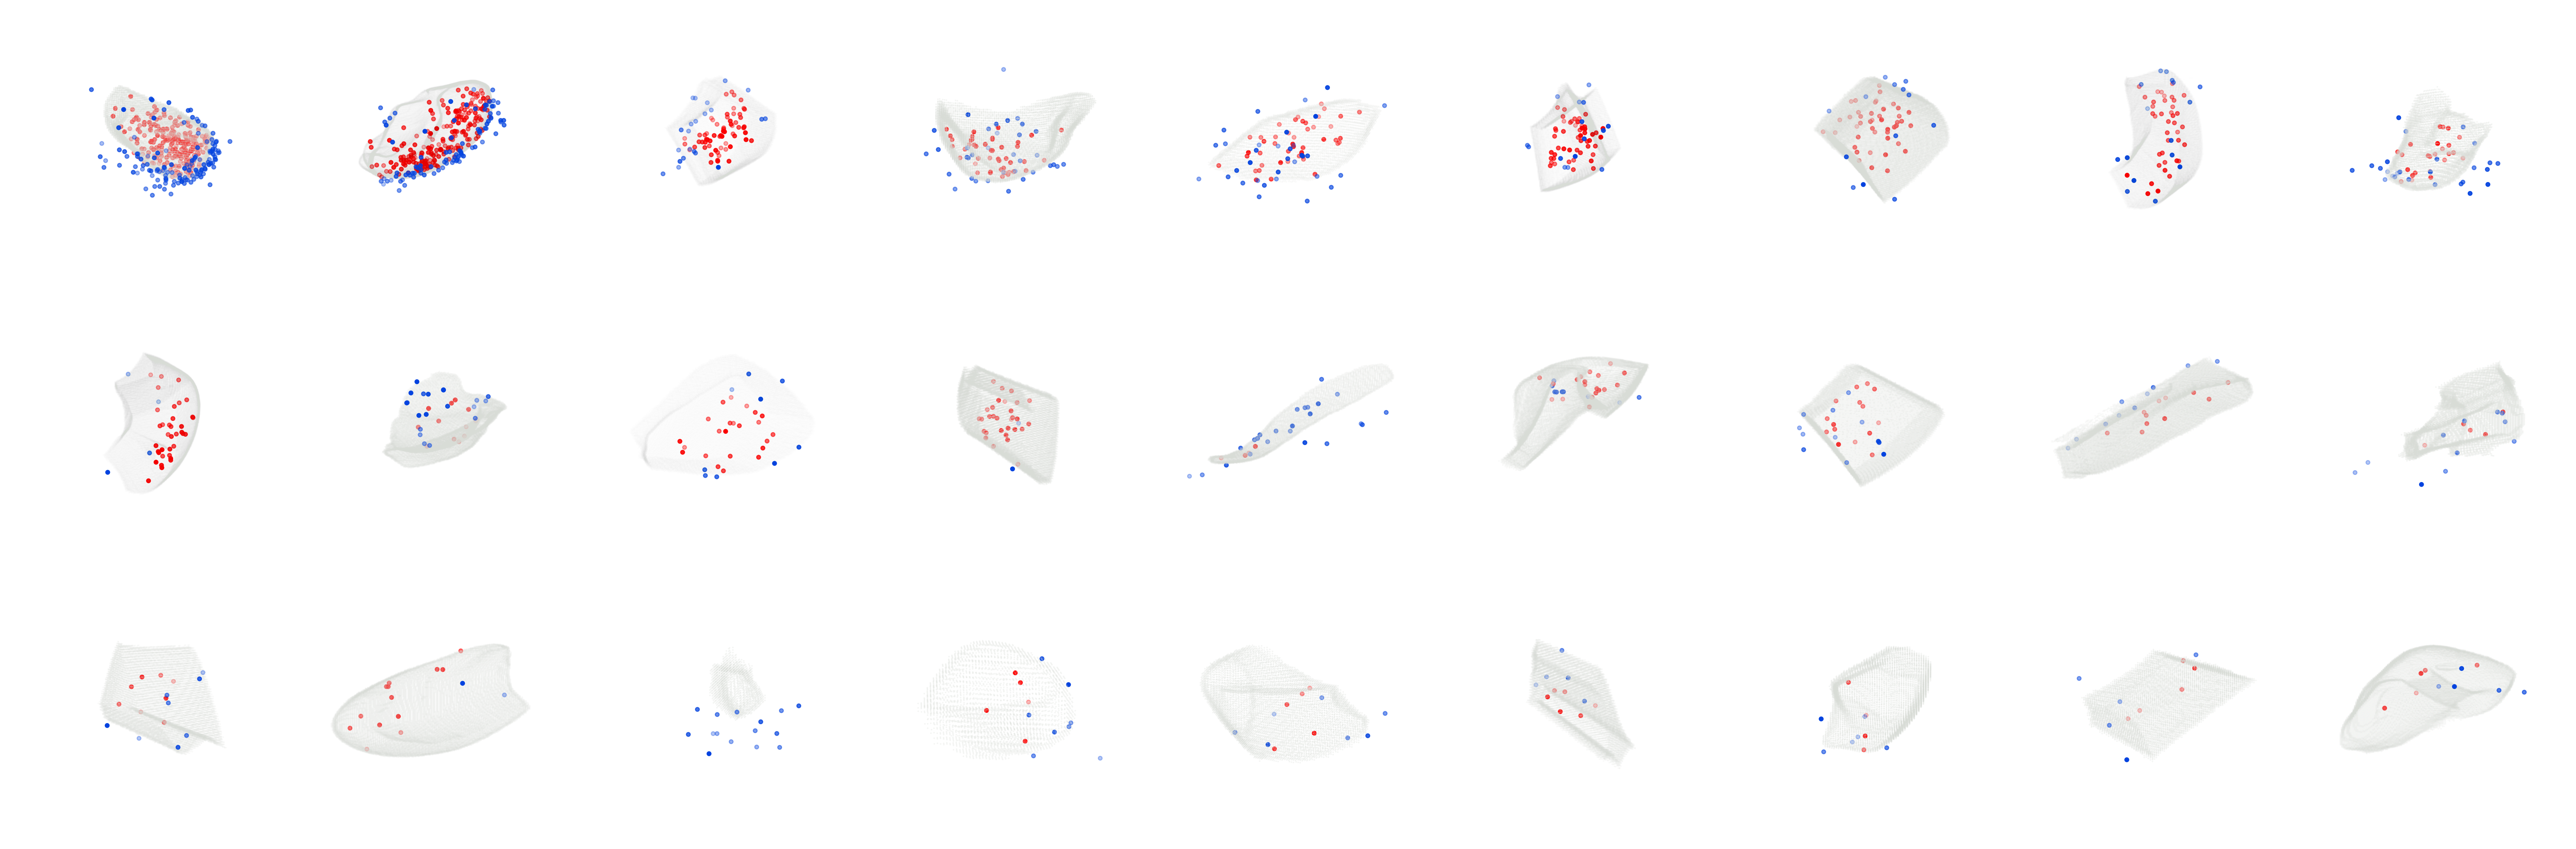

In [58]:
fig, axs = plt.subplots(3,9,figsize=(4*9,4*3),dpi=200,
                        subplot_kw={'projection': '3d'})
axs = axs.ravel()
for i,region in enumerate(ana_regions):
    reg_bf=os.path.join('./region_boundary',region+'_boundary.pickle')
    if not os.path.exists(reg_bf):
        continue
    with open(reg_bf,'rb') as f:
        reg_bdata=pickle.load(f)
    reg_bdatadf=pd.DataFrame(reg_bdata)

    ana_data_in=reg_validation[(reg_validation.manual_soma_region==region)&
                            (reg_validation.reg_soma_region==region)].copy()
    ana_data_out=reg_validation[(reg_validation.manual_soma_region==region)&
                            (reg_validation.reg_soma_region!=region)].copy()
    # fig=plt.figure(figsize=(4,4),dpi=150)
    ax=axs[i]
    # ax = fig.add_subplot(projection='3d')
    alpha=0.1
    if region in ['CP','SSs','MOp','MOs','SSp-m','VISp']:
        alpha=0.005
    elif region in ['VPM','VPL','LGD','MG','LP','LD','VPLpc','SMT','VM','VISrl']:
        alpha=0.2
    
    ax.scatter(reg_bdatadf[0],reg_bdatadf[1],reg_bdatadf[2],c='#d8dcd6',s=0.5,alpha=alpha)
    ax.scatter(ana_data_in['somax'],ana_data_in['somay'],ana_data_in['somaz'],c='red',s=15,label='Matched:'+str(ana_data_in.shape[0]))
    ax.scatter(ana_data_out['somax'],ana_data_out['somay'],ana_data_out['somaz'],c='#0343df',s=15,label='Unmatched:'+str(ana_data_out.shape[0]))
    # if legend:
    # plt.legend(loc='upper left',bbox_to_anchor=(0.2,0.96),title='',fontsize=12)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # # Now set color to white (or whatever is"invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    # ax.set_title(region+" (n= "+str(ana_data_in.shape[0]+ana_data_out.shape[0])+
    #           ')\nOut of region (n='+str(ana_data_out.shape[0])+')',fontsize=18,y=0.88)
    # plt.xlim([reg_bdatadf.min()[0]-10,reg_bdatadf.min()[0]+90])
    # plt.ylim([reg_bdatadf.min()[1]-10,reg_bdatadf.min()[1]+90])
    # ax.set_zlim([reg_bdatadf.min()[2]-10,reg_bdatadf.min()[2]+60])
    ax.set_axis_off()
    # ax.view_init(10,45)
    ax.view_init(10,135)
    # ax.view_init(0,90)
    # plt.tight_layout()
    # plt.show()
    # fig.savefig('./fig/'+str(ana_data_in.shape[0]+ana_data_out.shape[0])+region+'_soma_reg.png',dpi=300)
    # btype='TH'
    # if region in CNU:
    #     btype='CNU'
    # elif region in CTX:
    #     btype='CTX'
    # fig.savefig('./fig/'+btype+'_'+region+'_soma_reg.png',dpi=300)
    # break
plt.tight_layout()
plt.show()
fig.savefig('./fig/soma_reg_v1.png',dpi=300)

In [253]:
#debug
reg_bf=os.path.join('./region_boundary','MOp_boundary.pickle')
if os.path.exists(reg_bf):
    with open(reg_bf,'rb') as f:
        reg_bdata=pickle.load(f)
# show_b=pd.DataFrame(reg_bdata,columns=['x','y','z'])
show_ccf = np.zeros_like(nmt.annotation.array, dtype=np.uint32)
for p in reg_bdata:
    show_ccf[p[0],p[1],p[2]]=100
for cell in r1741df_raw[r1741df_raw.Manually_corrected_soma_region=='MOp'].index:
    swcf=os.path.join(swcdir,cell+'.swc')
    if not os.path.exists(swcf):
        continue
    inswc=nmt.swc.neuron(swcf).swc
    soma=inswc[inswc.parent<0].copy()
    sx=soma.iloc[0]['x']/25
    sy=soma.iloc[0]['y']/25
    sz=soma.iloc[0]['z']/25
    if cell == '18453_4221_x16935_y5165':
        print(sx)
    if sz > nmt.annotation.size['z']/2:
        sz= nmt.annotation.size['z'] - sz
    show_ccf[int(sx),int(sy),int(sz)]=250

211.31400000000002


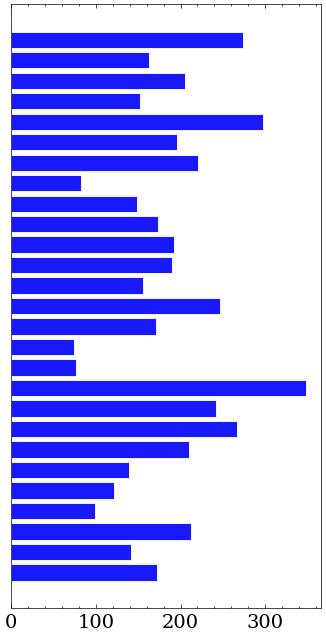

In [60]:
showdata=reg_validation[(reg_validation.manual_soma_region.isin(ana_regions))&(reg_validation.dist2_region_edge>0)].copy()
fig=plt.figure(figsize=(4,8),dpi=100)
ax=plt.subplot(111)
cnu_regions=[ 'CP',  'OT','ACB']
th_regions=['VPM', 'VPL','LGd', 'MG', 'RT', 'LP',
        'VPLpc', 'SMT','VM', 'LD']
ctx_regions=['SSp-m','SSs','SSp-bfd','MOp', 'MOs','VISp','SSp-ul', 'CLA',
             'RSPv','SSp-n','AId', 'SSp-ll','SSp-un', 'VISrl']

ax.barh(cnu_regions+th_regions+ctx_regions, [showdata.loc[showdata.manual_soma_region==r,'dist2_region_edge'].mean() for r in cnu_regions+th_regions+ctx_regions], 
        height=0.8, edgecolor="white", linewidth=0.7,color='blue',alpha=0.9)
# sns.barplot(data=showdata[showdata.dist2_region_edge>0],x='manual_soma_region',y='dist2_region_edge',
#             hue='brain_region',hue_order=btype,palette=sns.color_palette(bcolors))
# plt.xticks(rotation=90)
# plt.ylabel('Distance to region boundary (um)',fontsize=14)
# plt.title('Unmatched somata',fontsize=14)
# plt.xlabel('',fontsize=14)
plt.yticks([],fontsize=12)
plt.xticks(fontsize=14)
plt.show()
fig.savefig('./fig/reg_validation_unmatched_dist.png',dpi=300)

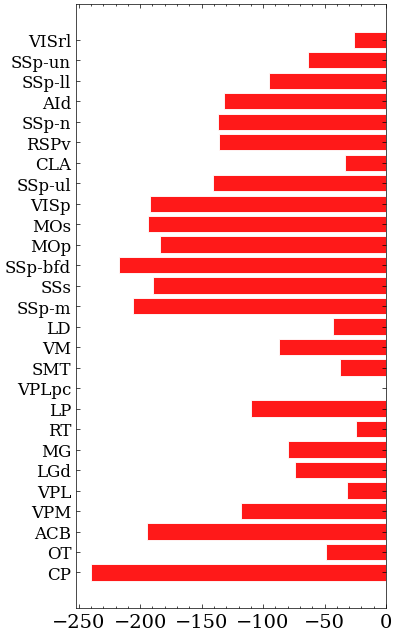

In [62]:
showdata=reg_validation[(reg_validation.manual_soma_region.isin(ana_regions))&(reg_validation.dist2_region_edge<=0)].copy()
fig=plt.figure(figsize=(4,8),dpi=100)
ax=plt.subplot(111)
all_show_regions=cnu_regions+th_regions+ctx_regions
ax.barh(all_show_regions, [showdata.loc[showdata.manual_soma_region==r,'dist2_region_edge'].mean() for r in all_show_regions], 
        height=0.8, edgecolor="white", linewidth=0.7,color='red',alpha=0.9)
# sns.barplot(data=showdata[showdata.dist2_region_edge>0],x='manual_soma_region',y='dist2_region_edge',
#             hue='brain_region',hue_order=btype,palette=sns.color_palette(bcolors))
# plt.xticks(rotation=90)
# plt.ylabel('Distance to region boundary (um)',fontsize=14)
# plt.title('Unmatched somata',fontsize=14)
# plt.xlabel('',fontsize=14)
plt.yticks(ticks=np.arange(len(all_show_regions)),labels=all_show_regions,fontsize=12)
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_minor_locator(MaxNLocator(1))
plt.xticks(fontsize=14)
plt.show()
fig.savefig('./fig/reg_validation_matched_dist.png',dpi=300)

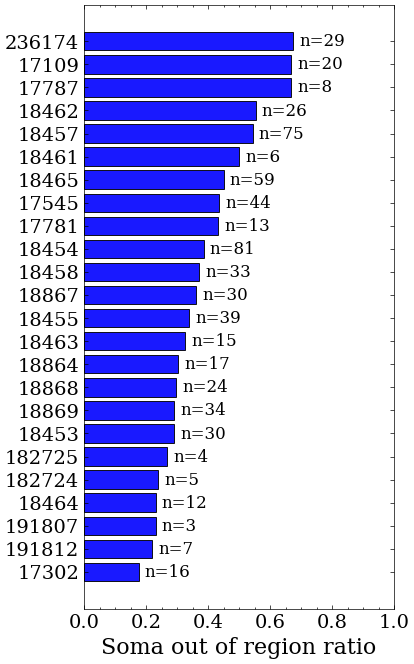

In [63]:
mratio_df=pd.DataFrame()
allbrains=reg_validation['brain'].value_counts().keys().to_list()
for brain in allbrains:
    this_brain=reg_validation[(reg_validation.brain==brain)].copy()
    match_ratio=this_brain[(this_brain.dist2_region_edge>0)].shape[0]/this_brain.shape[0]
    mratio_df.loc[brain,'out_ratio']=match_ratio
    mratio_df.loc[brain,'neurons']=this_brain.shape[0]
mratio_df.index.name='brain'
fig=plt.figure(figsize=(4,8),dpi=100)
ax=plt.subplot(111)
showdata=mratio_df[mratio_df.neurons>10].copy()
showdata.sort_values(by='out_ratio',ascending=True,inplace=True)
ax.barh(np.arange(showdata.shape[0]), showdata['out_ratio'], height=0.8, edgecolor="black",
        color='blue', alpha=0.9,
        linewidth=0.7)
# ax.text(0.2,-0.4,'dd')
for i,b in enumerate(showdata.index.to_list()):
    ax.text(showdata.loc[b,'out_ratio']+0.02,i-0.2,
            'n='+str(int(showdata.loc[b,'neurons']*showdata.loc[b,'out_ratio'])),
            fontsize=12)
# ax.set_xticks(allbrains)
# ax.set_yticklabels(allbrains)
# plt.xticks(rotation=45)
# plt.title('Unmatched ratio for each brain')
plt.xlim([0,1])
plt.yticks(np.arange(showdata.shape[0]),
           labels=showdata.index.to_list(),fontsize=14)
plt.xticks(fontsize=14)
ax.yaxis.set_minor_locator(MaxNLocator(1))
plt.xlabel('Soma out of region ratio',fontsize=16)
plt.show()
fig.savefig('./fig/reg_validation_unmatched_brain_ratio.png',dpi=300)